# Sixth exercice: Non-Cartesian spiral under-sampling

In this notebook, you can play with the design parameters to regenerate different spiral in-out patterns (so, we draw as many spiral arches as the number of shots). You can play with the number of shots by changing the under-sampling factor.

- Authors: Philippe Ciuciu (philippe.ciuciu@cea.fr)
- Date: 04/02/2019
- Target: [ISBI'19 tutorial](https://biomedicalimaging.org/2019/tutorials/) on **Recent  advances in acquisition and reconstruction for Compressed Sensing MRI**
- **Revision**: 01/06/2021 for ATSI MSc hands-on session at Paris-Saclay University.

/home/ciuciu/work/code/git/pysap-mri/mri/operators/fourier/cartesian.py:27: UserWarning: pynfft python package has not been found. If needed use the master release.
  warnings.warn("pynfft python package has not been found. If needed use "
/home/ciuciu/work/code/git/pysap-mri/mri/operators/fourier/cartesian.py:33: UserWarning: pynufft python package has not been found. If needed use the master release. Till then you cannot use NUFFT on GPU
  warnings.warn("pynufft python package has not been found. If needed use "
/home/ciuciu/work/code/git/pysap-mri/mri/operators/fourier/non_cartesian.py:27: UserWarning: pynfft python package has not been found. If needed use the master release.
  warnings.warn("pynfft python package has not been found. If needed use "
/home/ciuciu/work/code/git/pysap-mri/mri/operators/fourier/non_cartesian.py:33: UserWarning: pynufft python package has not been found. If needed use the master release. Till then you cannot use NUFFT on GPU
  warnings.warn("pynufft pyt

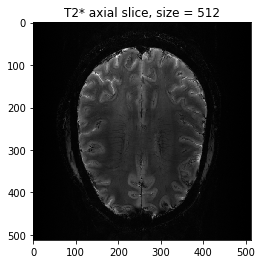

In [17]:
#DISPLAY BRAIN PHANTOM
%matplotlib inline

import numpy as np
import os.path as op
import os
import math ; import cmath
import matplotlib.pyplot as plt
import sys
from mri.operators import NonCartesianFFT
from mri.operators.utils import convert_locations_to_mask, \
    gridded_inverse_fourier_transform_nd
from pysap.data import get_sample_data


from skimage import data, img_as_float, io, filters
from modopt.math.metrics import ssim

mri_img = get_sample_data('2d-mri')
img_size = mri_img.shape[0]

plt.figure()
plt.title("T2* axial slice, size = {}".format(img_size))
if mri_img.ndim == 2:
    plt.imshow(mri_img, cmap=plt.cm.gray)
else:
    plt.imshow(mri_img)
plt.show()

In [18]:
def complex_to_2d(points):
    X = points.real
    Y = points.imag
    return np.asarray([X, Y]).T

number of shots: 128
number of samples: 256
number of samples per shot: 512
(65536,)


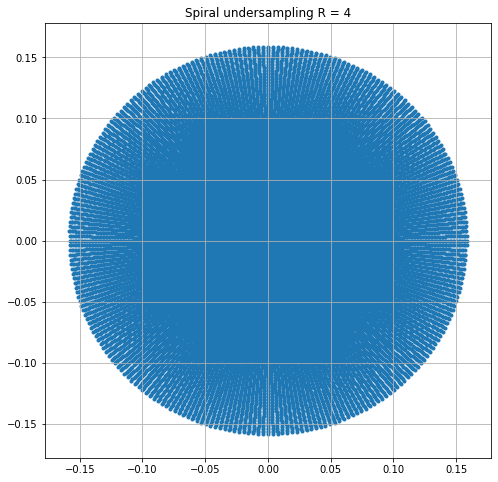

In [42]:
# set up the first shot
rfactor = 4
num_shots = math.ceil(img_size/rfactor)
print("number of shots: {}".format(num_shots))

# define the regularly spaced samples on a single shot
#nsamples = (np.arange(0,img_size) - img_size//2)/(img_size)
num_samples = img_size
num_samples = (num_samples + 1) // 2
print("number of samples: {}".format(num_samples))
num_revolutions = 1

shot = np.arange(0, num_samples, dtype=np.complex_)
radius = shot / num_samples * 1 / (2 * np.pi) * (1 - np.finfo(float).eps)
angle = np.exp(2 * 1j * np.pi * shot / num_samples * num_revolutions)
# first half of the spiral
single_shot = np.multiply(radius, angle)
# add second half of the spiral
#single_shot = np.append(np.flip(single_shot, axis=0), -single_shot[1:])
single_shot = np.append(np.flip(single_shot, axis=0), -single_shot)
#print(single_shot)
print("number of samples per shot: {}".format(np.size(single_shot)))

# vectorize the nb of shots    
#vec_shots = np.arange(0,nb_shots + 1)

k_shots = np.array([], dtype = np.complex_)  
#for i in vec_shots:
for i in np.arange(0, num_shots):
    shot_rotated = single_shot * np.exp(1j * 2 * np.pi * i / (num_shots * 2))
    k_shots = np.append(k_shots, shot_rotated)
    #np.append(k_shots, complex_to_2d(shot_rotated))

print(k_shots.shape)
kspace_loc = np.zeros((len(k_shots),2))
kspace_loc[:,0] = k_shots.real
kspace_loc[:,1] = k_shots.imag

#Plot full initialization
kspace = plt.figure(figsize = (8,8))
#plot shots
plt.scatter(kspace_loc[::2,0], kspace_loc[::2,1], marker = '.')
plt.title("Spiral undersampling R = %d" %rfactor)

axes = plt.gca() 
plt.grid()


In [32]:
print(np.arange(0, num_shots))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127]


In [29]:
data=convert_locations_to_mask(kspace_loc, mri_img.shape)
fourier_op = NonCartesianFFT(samples=kspace_loc, shape=mri_img.shape,
                             implementation='cpu')
kspace_obs = fourier_op.op(mri_img.data)

NameError: name 'pynfft' is not defined

In [17]:
grid_space = np.linspace(-0.5, 0.5, num=mri_img.shape[0])
grid2D = np.meshgrid(grid_space, grid_space)
grid_soln = gridded_inverse_fourier_transform_nd(kspace_loc, kspace_obs,
                                                 tuple(grid2D), 'linear')
plt.imshow(np.abs(grid_soln), cmap='gray')
# Calculate SSIM
base_ssim = ssim(grid_soln, mri_img)
plt.title('Gridded Solution\nSSIM = ' + str(base_ssim))
plt.show()

NameError: name 'kspace_obs' is not defined